In [2]:
#importing necessary libraries

import numpy as np
from numpy import expand_dims
import pandas as pd
import seaborn as sns
import tensorflow
import keras
import os
import glob
from skimage import io
import skimage
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import random
import matplotlib.pyplot as plt
import cv2
from keras_preprocessing.image import ImageDataGenerator
from keras.datasets import mnist
import math

In [4]:
#loading training and testing data

train=pd.read_csv('data/train.csv')
print(train.shape)
print(train.head())

test=pd.read_csv('data/test.csv')
print(test.shape)
print(test.head())

act_test=pd.read_csv("fer2013.csv")
print(act_test.shape)
print(act_test.head())

(28709, 2)
   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
(7178, 1)
                                              pixels
0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1  156 184 198 202 204 207 210 212 213 214 215 21...
2  69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3  205 203 236 157 83 158 120 116 94 86 155 180 2...
4  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


FileNotFoundError: [Errno 2] No such file or directory: 'fer2013.csv'

In [ ]:
#we need 5 classes so we drop the 2 with the least data to help balance out the model
# X_train=X_train[~X_train]

In [5]:
#relabling data. NOTE THAT LABEL ENCODING ASSIGNS LABELS BY ALPHABETICAL ORDER AND THEREFORE THE LAST 3 LABELS WOULD BE DIFFERENT
train['emotion']=train['emotion'].map({0:"angry",1:"disgust",2:"fear",3:"happy",4:"sad",5:"surprise",6:"neutral"})
print(train["emotion"].unique())
le=LabelEncoder()
train['emotion']=le.fit_transform(train['emotion'])
print(train["emotion"].head(10))

['angry' 'fear' 'sad' 'neutral' 'happy' 'surprise' 'disgust']
0    0
1    0
2    2
3    5
4    4
5    2
6    5
7    3
8    3
9    2
Name: emotion, dtype: int64


In [6]:
#relabling actual test result. ALSO REORDERED ALPHABETICALLY
act_test['emotion']=act_test['emotion'].map({0:"angry",1:"disgust",2:"fear",3:"happy",4:"sad",5:"surprise",6:"neutral"})
print(act_test["emotion"].unique())
le=LabelEncoder()
act_test['emotion']=le.fit_transform(act_test['emotion'])
print(act_test["emotion"].head(10))

NameError: name 'act_test' is not defined

In [7]:
#decode data usage in order to know which cells we're choosing
print(act_test['Usage'].unique())
le=LabelEncoder()
act_test['Usage']=le.fit_transform(act_test['Usage'])
print(act_test['Usage'].unique())


NameError: name 'act_test' is not defined

In [6]:
#assign features and target of both training and testing data
Y_train=train['emotion']
Y_test = act_test.loc[act_test['Usage'].isin([0, 1]), 'emotion']
X_train=train['pixels']
X_test=test['pixels']

print("X_train shape is: ", X_train.shape)
print("X_test shape is: ", X_test.shape)
print("Y_train shape is: ", Y_train.shape)
print("Y_test shape is: ", Y_test.shape)
print(type(X_train))
print(type(X_test))
print(type(Y_train))
print(type(Y_test))
# print(Y_test)

X_train shape is:  (28709,)
X_test shape is:  (7178,)
Y_train shape is:  (28709,)
Y_test shape is:  (7178,)
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [7]:
print(Y_train.isnull().sum())
print(Y_test.isnull().sum())

0
0


In [8]:
# Convert the space-separated pixel strings to numeric arrays
X_train_arr = np.array([np.fromstring(img, sep=' ') for img in X_train])
X_test_arr  = np.array([np.fromstring(img, sep=' ') for img in X_test])

print(type(X_train_arr))  
print(type(X_test_arr))   


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [9]:
#unflattening data for preprocessing
X_train_unflattened = X_train_arr.reshape(-1, 48, 48)
print(X_train_unflattened.shape)
X_test_unflattened = X_test_arr.reshape(-1, 48, 48)
print(X_test_unflattened.shape)

(28709, 48, 48)
(7178, 48, 48)


2 255


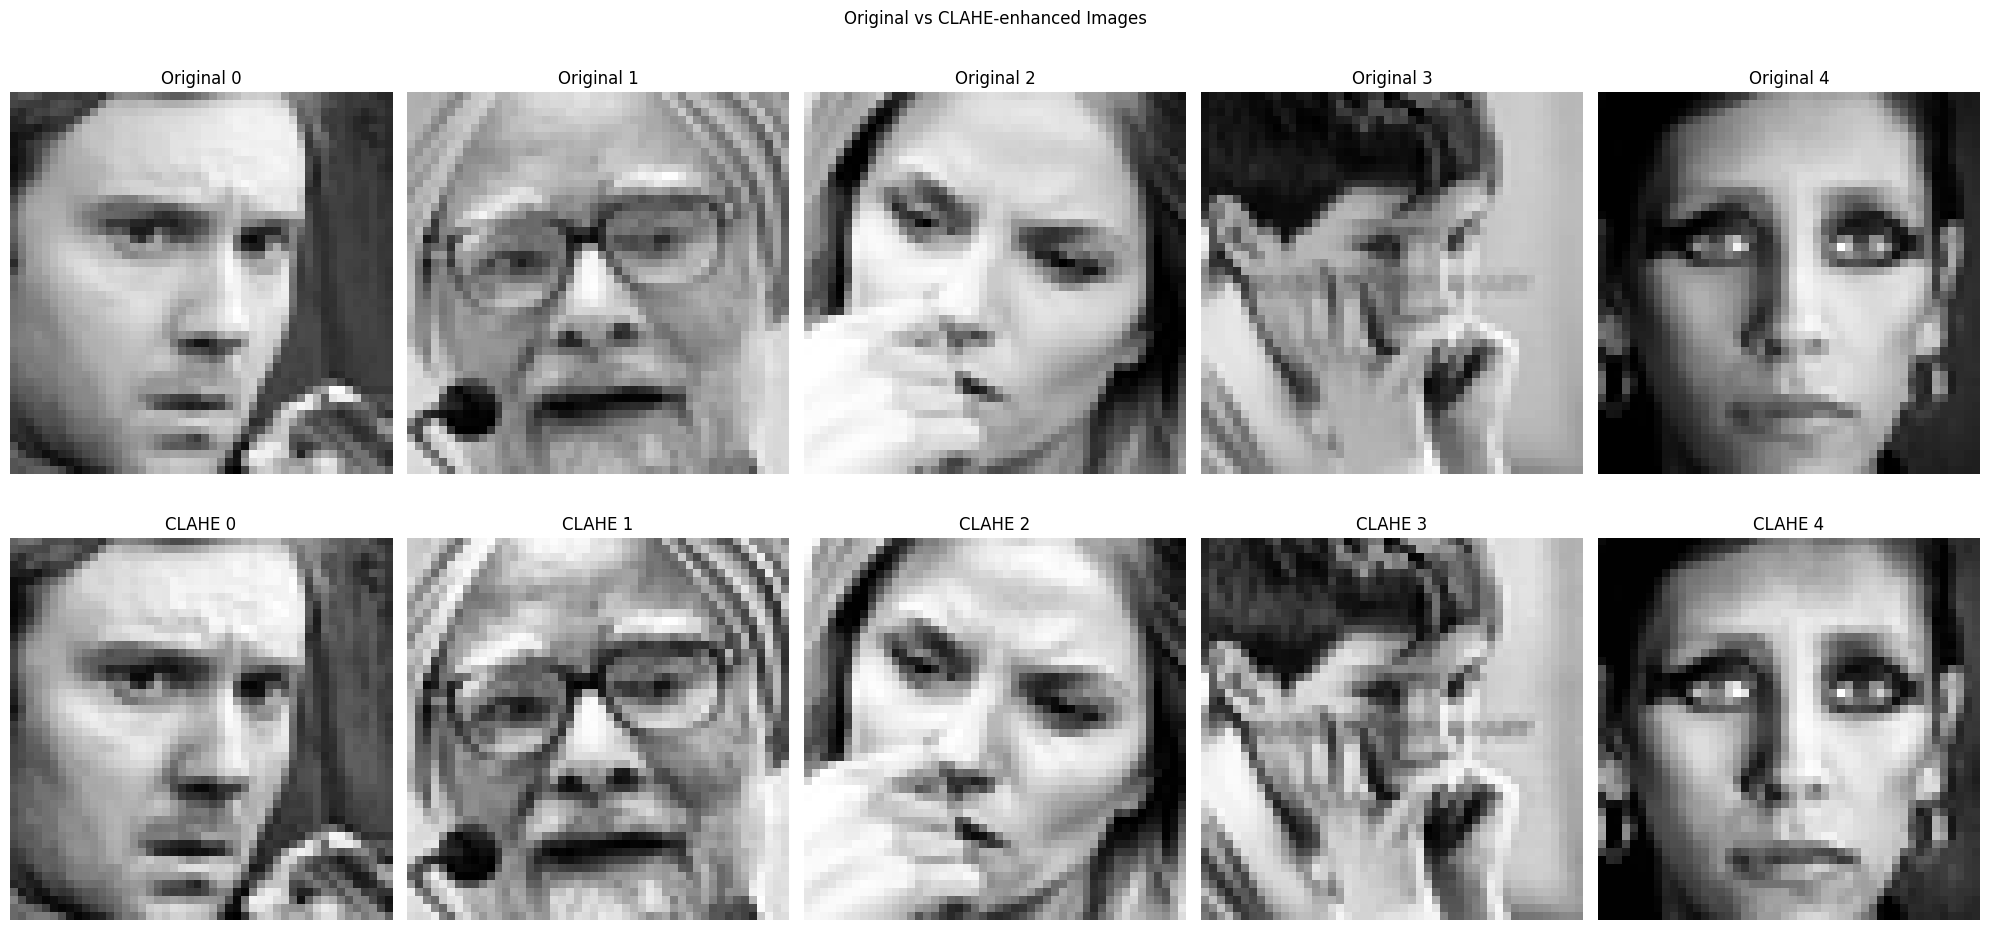

In [63]:
#CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
X_train_uint8 = X_train_unflattened.astype(np.uint8)
X_test_uint8 = X_test_unflattened.astype(np.uint8)

# Apply CLAHE to every image
X_train_clahe = np.array([clahe.apply(img) for img in X_train_uint8], dtype=np.uint8)

# Similarly, for test set if needed
X_test_clahe = np.array([clahe.apply(img) for img in X_test_uint8], dtype=np.uint8)

print(X_train_clahe.min(), X_train_clahe.max())  # e.g., 0 255

num_samples = 5

plt.figure(figsize=(20, 10))

for i in range(num_samples):
    # Original image
    plt.subplot(2, num_samples, i+1)
    plt.imshow(X_train_uint8[i], cmap='gray')
    plt.title(f"Original {i}")
    plt.axis("off")
    
    # CLAHE image
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(X_train_clahe[i], cmap='gray')
    plt.title(f"CLAHE {i}")
    plt.axis("off")

plt.suptitle("Original vs CLAHE-enhanced Images")
plt.tight_layout()
plt.show()

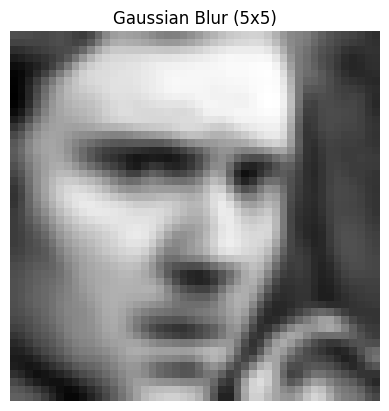

In [67]:
#Gaussian high-pass filtering
X_train_gauss = np.array([cv2.GaussianBlur(img, (5,5), 0) for img in X_train_clahe], dtype=np.uint8)
X_test_gauss  = np.array([cv2.GaussianBlur(img, (5,5), 0) for img in X_test_clahe], dtype=np.uint8)

# Optional: visualize one example
plt.imshow(X_train_gauss[0], cmap='gray')
plt.title("Gaussian Blur (5x5)")
plt.axis("off")
plt.show()

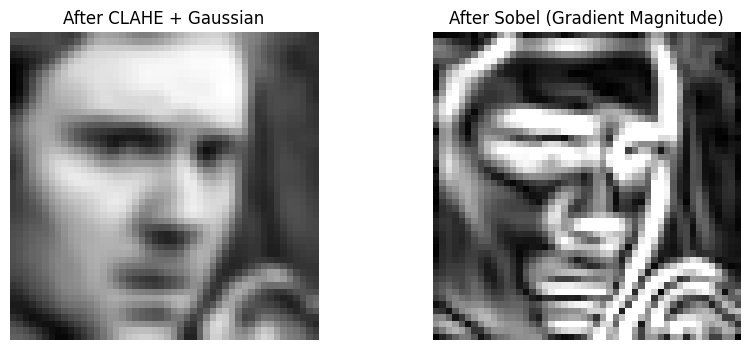

In [72]:
#sobel low-pass filtering
X_train_sobel = []

for img in X_train_gauss:
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    # Compute gradient magnitude
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    # Convert back to 0-255 uint8 for consistency
    grad_mag = np.uint8(np.clip(grad_mag, 0, 255))
    X_train_sobel.append(grad_mag)

X_train_sobel = np.array(X_train_sobel, dtype=np.uint8)
X_test_sobel = []

for img in X_test_gauss:
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    # Compute gradient magnitude
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    # Convert back to 0-255 uint8 for consistency
    grad_mag = np.uint8(np.clip(grad_mag, 0, 255))
    X_test_sobel.append(grad_mag)

X_test_sobel = np.array(X_test_sobel, dtype=np.uint8)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(X_train_gauss[0], cmap='gray')
plt.title("After CLAHE + Gaussian")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(X_train_sobel[0], cmap='gray')
plt.title("After Sobel (Gradient Magnitude)")
plt.axis("off")

plt.show()

Batch shape: (28709, 48, 48, 1)


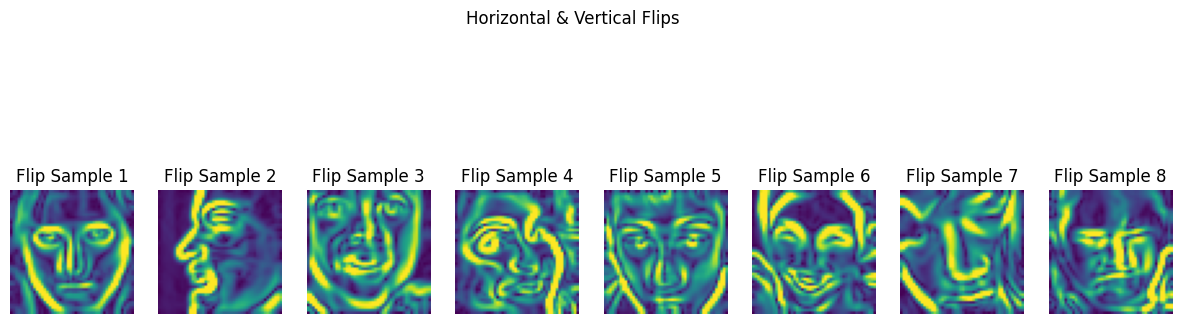

In [ ]:
# data augmentation (generating extra samples from existing ones). takes clean data
# generating flipped + rotated images
samples=expand_dims(X_train_sobel.astype('float32'),axis=-1)
print("Batch shape:" , samples.shape)
augmented_images = []
augmented_labels = []

num_aug = 3  # number of augmentations per image
batch_size = 32

data_gen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360,
    fill_mode='nearest'
)

iterator = data_gen.flow(samples, Y_train, batch_size=batch_size)


# Plot some flipped images
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(15, 5))

for i in range(8):
    # Get a batch (1 image), take first image
    batch = next(iterator)[0].astype('uint8')
    axes[i].imshow(batch)
    axes[i].set_title(f"Flip Sample {i+1}")
    axes[i].axis("off")

plt.suptitle("Horizontal & Vertical Flips")
plt.show()

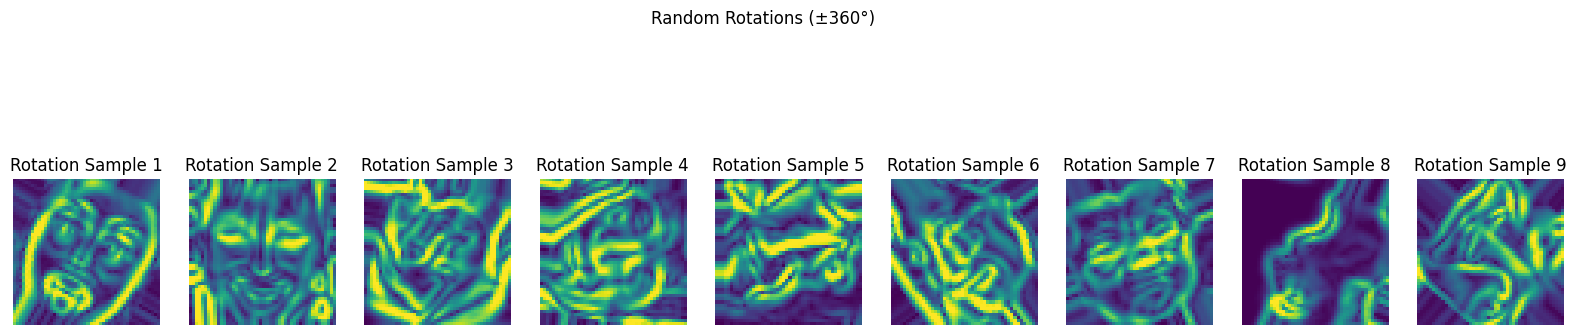

In [74]:
#generate rotated images
data_gen = ImageDataGenerator(rotation_range=360, fill_mode='nearest')

it = data_gen.flow(samples, batch_size=32)

# Plot some flipped images
fig, axes = plt.subplots(nrows=1, ncols=9, figsize=(20, 5))

for i in range(9):
    # Get a batch (1 image), take first image
    batch = next(it)[0].astype('uint8')
    axes[i].imshow(batch)
    axes[i].set_title(f"Rotation Sample {i+1}")
    axes[i].axis("off")

plt.suptitle("Random Rotations (±360°)")
plt.show()


In [76]:
#data normalization
print("Before normalization:")
print("x_train min:", X_train.min())
print("x_train max:", X_train.max())
X_train_norm = X_train_sobel.astype(np.float32)/255.0
X_test_norm = X_test_sobel.astype(np.float32)/255.0
# norm_image = (X_train - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))
print("x_train shape: ",X_train_norm.shape)
print("x_test shape: ",X_test_norm.shape)
print("After normalization:")
print("x_train min:", X_train_norm.min())
print("x_train max:", X_train_norm.max())
plt.show()

Before normalization:
x_train min: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [13]:
# #visualizing rgb channels
# original_data = skimage.color.gray2rgb(X_train[-1])
# plt.imshow(original_data)  # display the whole image
# plt.axis('off')
# plt.show()

# fig, (im1, im2, im3, im4) = plt.subplots(1, 4, sharey=True, figsize=(20,5))

# im1.imshow(original_data)          # Full RGB (still gray)
# im2.imshow(original_data[:, :, 0], cmap='Reds')   # Red channel
# im3.imshow(original_data[:, :, 1], cmap='Greens') # Green channel
# im4.imshow(original_data[:, :, 2], cmap='Blues')  # Blue channel

# fig.suptitle("Original RGB and Separate Channels")
# plt.show()


In [ ]:
#applying pca
# print("Original shape:", X_train.shape)

# pca = PCA(n_components=100)
# X_train = pca.fit_transform(X_train)

# print("Reduced shape:", X_train.shape)

C:\Users\danae\AppData\Local\Temp\ipykernel_3676\662347986.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=Y_train, palette="icefire")


emotion
3    7215
4    4965
5    4830
2    4097
0    3995
6    3171
1     436
Name: count, dtype: int64

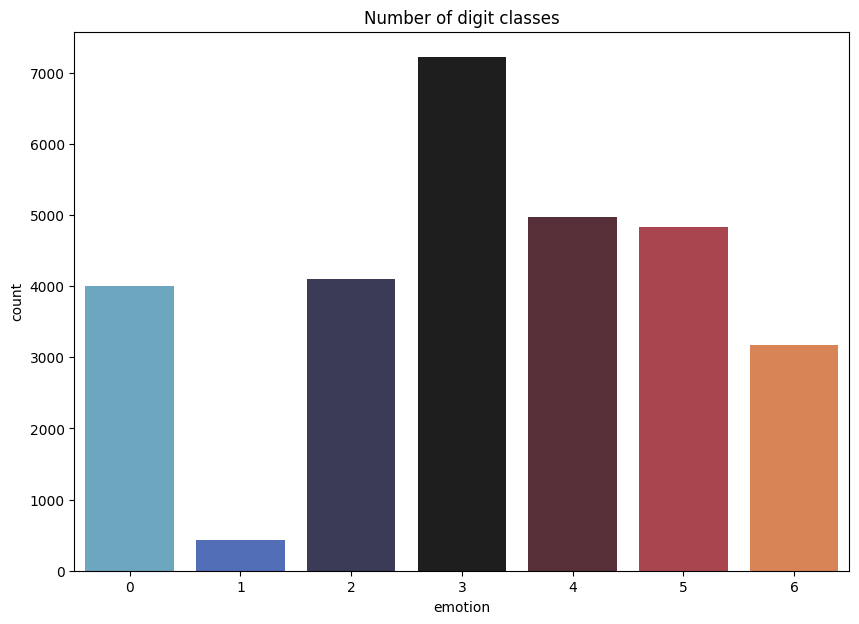

In [14]:
#plotting target

plt.figure(figsize=(10,7))
sns.countplot(x=Y_train, palette="icefire")
plt.title("Number of digit classes")
Y_train.value_counts()

In [77]:
#reflattening for knn
X_train_flattened = X_train_norm.reshape(len(X_train), -1)
X_test_flattened = X_test_norm.reshape(len(X_test), -1)

print("X_train shape:", X_train_flattened.shape)
print("X_test shape:", X_test_flattened.shape)

X_train shape: (28709, 2304)
X_test shape: (7178, 2304)


In [78]:
# Initialize the K-NN classifier
k =3 # Number of neighbors
print(k)
knn = KNeighborsClassifier(n_neighbors=k, metric = 'minkowski', p = 2)

# Train the model
knn.fit(X_train_flattened, Y_train)

3


,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [18]:
# model=LogisticRegression()
# model.fit(iterator, epochs=10)
# print('modeltrained successfully')

In [79]:
Y_pred = knn.predict(X_test_flattened)

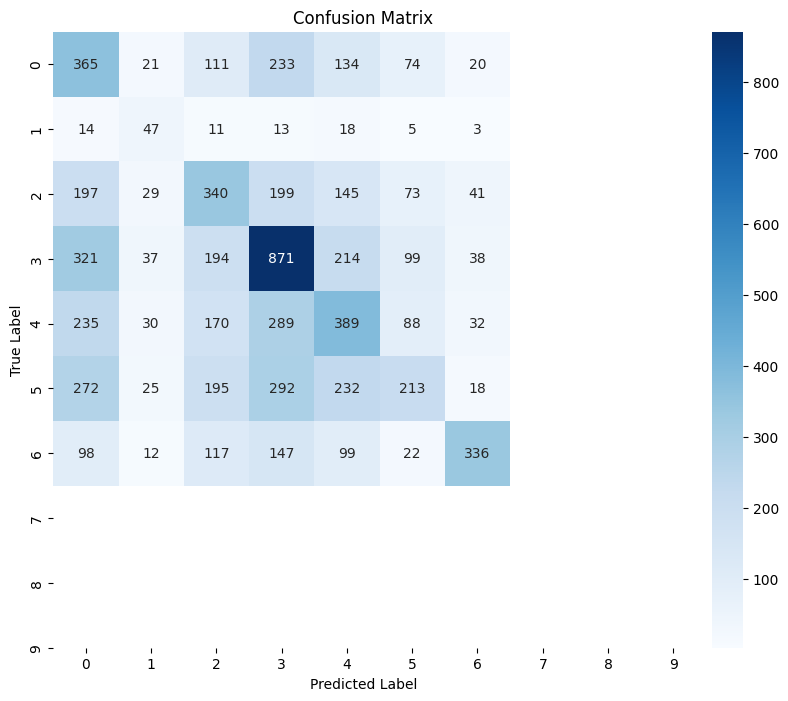

In [80]:
# Compute the confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [81]:
accuracy_score(Y_test,Y_pred)

0.3567846196712176

ValueError: cannot reshape array of size 2304 into shape (28,28)

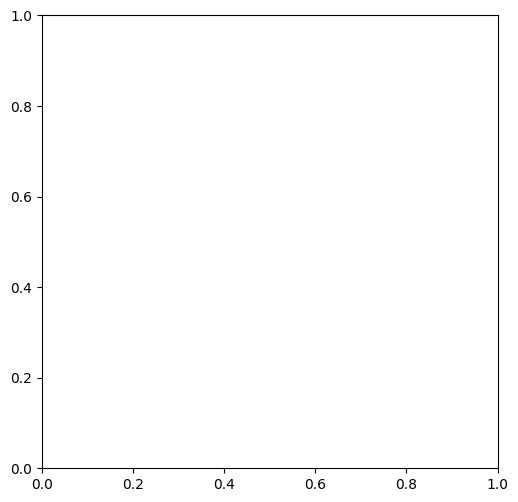

In [ ]:
# Visualize a few predictions
plt.figure(figsize=(20, 20))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {Y_test[i]}, Pred: {Y_pred[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()